In [1]:
import os

import sys
sys.path.append('./image_classification_model_utils.py')

import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from image_classification_model_utils import activation,compute_cost,activation_backward,update_parameters

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
import sys

def load_dataset(train_data_set,test_data_set):
    train_dataset = h5py.File(str(train_data_set), "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(str(test_data_set), "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
 
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:
train_data_set = './datasets/train_catvnoncat.h5'
test_data_set = './datasets/test_catvnoncat.h5'

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset(train_data_set,test_data_set)

y = 0. It's a non-cat picture.


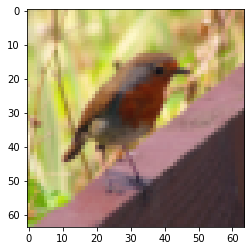

In [4]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ". It's a " + classes[train_set_y[0, index]].decode("utf-8") + " picture.")

In [5]:

m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [7]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [8]:
def model(X, Y, layer_dims, num_iterations=10, learning_rate=0.0075, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)

    n_x = layer_dims[0]
    n_y = layer_dims[2]
    n_h = layer_dims[1]
    
    grads = {}
    costs = [] 
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Loop (gradient descent)
    for i in range(0, num_iterations):  
        
        #calculate the A2
        A1,cache1 = activation(X, W1, b1, 'relu')
        A2,cache2 = activation(A1, W2, b2, 'sigmoid')

        #calculate the cost 
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation why ?
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1.reshape(db1.size,1)
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
      
        
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.672446095469852
Cost after iteration 200: 0.661949410818267
Cost after iteration 300: 0.6561171667550321
Cost after iteration 400: 0.6523519073968141
Cost after iteration 500: 0.649195753862597
Cost after iteration 600: 0.6467072392536188
Cost after iteration 700: 0.6443454477053603
Cost after iteration 800: 0.6409150311220639
Cost after iteration 900: 0.636122282297964
Cost after iteration 1000: 0.6313386272018741
Cost after iteration 1100: 0.6266954635963105
Cost after iteration 1200: 0.6221398950406264
Cost after iteration 1300: 0.6176818474652728
Cost after iteration 1400: 0.6133358220032549
Cost after iteration 1500: 0.6091073454533925
Cost after iteration 1600: 0.6049701709350596
Cost after iteration 1700: 0.600907880224244
Cost after iteration 1800: 0.5968939033875547
Cost after iteration 1900: 0.592968104226911
Cost after iteration 2000: 0.5891473114667717
Cost after iteration 2100: 0.585404376224462
Cost aft

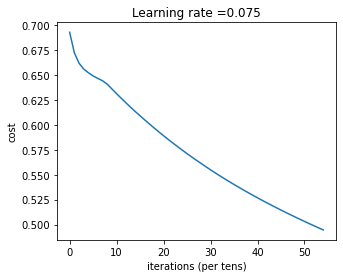

In [9]:
layer_dims = [12288,7,1]
parameters =  model(train_x, train_set_y ,layer_dims, num_iterations=5500, learning_rate=0.075, print_cost=True)

In [10]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    A1,cache1 = activation(X, parameters['W1'], parameters['b1'], 'relu')
    A2,cache2 = activation(A1, parameters['W2'], parameters['b2'], 'sigmoid')
    
    # convert probas to 0/1 predictions
    for i in range(0, A2.shape[1]):
        if A2[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [11]:
pred_train = predict(train_x, train_set_y, parameters)

Accuracy: 0.8133971291866029


In [12]:
pred_test = predict(test_x, test_set_y, parameters)

Accuracy: 0.6
